In [1]:
import numpy as np
import librosa 
import librosa.display
import matplotlib.pyplot as plt

In [2]:
y, sr = librosa.load(".\\babble_16k.wav")

In [4]:
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
beat_times = librosa.frames_to_time(beat_frames, sr=sr)


AttributeError: '_process_plot_var_args' object has no attribute 'prop_cycler'

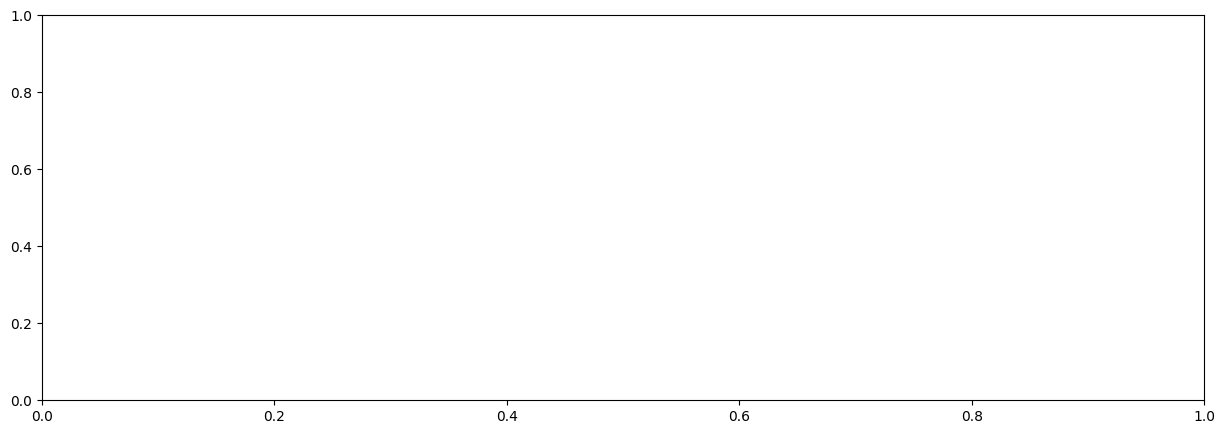

In [6]:
plt.figure(figsize=(15,5))
librosa.display.waveshow(y, sr=sr) 
plt.xlabel('time (s)') 
plt.ylabel('amplitude')
plt.title('noise signal')
plt.show()

In [7]:
import os
data_directory = ".\\intro-disclaimers"
durations = []

def process_directory(directory):
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)

        if os.path.isdir(item_path):
            process_directory(item_path)
        
        elif item.endswith('.flac'):
            cl, sr_cl = librosa.load(item_path, sr=None)
            duration = librosa.get_duration(y=cl, sr=sr_cl)
            durations.append(duration)


process_directory(data_directory)
average_duration = sum(durations) / len(durations)
print(f"Durée moyenne des audios: {average_duration:.2f} secondes")


Durée moyenne des audios: 11.28 secondes


In [8]:

import soundfile as sf
noise_directory =".\\noise"
segment_length = int(sr * 11.28)  

for start in range(0, len(y), segment_length):
    end = start + segment_length
    segment = y[start:end]
    output_path = os.path.join(noise_directory, f'segment_{start//segment_length}.wav')

    sf.write(output_path, segment, sr)


In [9]:
from random import choice as rand_choice
import soundfile as sf
import os
from sklearn.model_selection import train_test_split

noisy_audio_directory = ".\\noisy_audio"

def process_directory(directory):
    audio_data = []

    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)

        if os.path.isdir(item_path):
            audio_data.extend(process_directory(item_path))
        elif item.endswith('.flac'):
            voice, sr_voice = librosa.load(item_path, sr=None)
            audio_data.append((voice, sr_voice, item_path))  # Ajout du chemin du fichier

    return audio_data

audio_data = process_directory(data_directory)
voice_paths = []
noisy_paths = []
noise_paths = []
for voice, sr_voice, voice_path in audio_data:
    if len(voice) <= segment_length:
        noise_files = [f for f in os.listdir(noise_directory) if f.endswith('.wav')]
        random_noise_file = rand_choice(noise_files)
        noise_segment_path = os.path.join(noise_directory, random_noise_file)
        noise, sr_noise = librosa.load(noise_segment_path, sr=None)

        if sr_noise != sr_voice:
            noise = librosa.resample(noise, orig_sr=sr_noise, target_sr=sr_voice)
            sr_noise = sr_voice

        if len(voice) > len(noise):
            voice = voice[:len(noise)]
        else:
            noise = noise[:len(voice)]

        output_directory = os.path.join(noisy_audio_directory, "voice_noise_pairs")
        if not os.path.exists(output_directory):
            os.makedirs(output_directory)

        voice_directory = os.path.join(output_directory, "voice")
        if not os.path.exists(voice_directory):
            os.makedirs(voice_directory)

        noisee_directory = os.path.join(output_directory, "noise")
        if not os.path.exists(noisee_directory):
            os.makedirs(noisee_directory)

        voice_noisy_directory = os.path.join(output_directory, "voice_noisy")
        if not os.path.exists(voice_noisy_directory):
            os.makedirs(voice_noisy_directory)

        voice_output_path = os.path.join(voice_directory, f'original_{os.path.basename(voice_path)}')
        sf.write(voice_output_path, voice, sr_voice)

        noisy_output_path = os.path.join(voice_noisy_directory, f'noisy_{os.path.basename(voice_path)}')
        
         
        sf.write(noisy_output_path, voice + noise, sr_voice)

        noise_output_path = os.path.join(noisee_directory, f'noise_{os.path.basename(voice_path)}')
       
        sf.write(noise_output_path, noise, sr_voice)

        voice_paths.append(voice_output_path)
        noisy_paths.append(noisy_output_path)
        noise_paths.append(noise_output_path)

RuntimeError: System error.

In [20]:

import torch.nn as nn
class STFTNormalizer:
    def __init__(self, n_fft, hop_length):
        self.n_fft = n_fft
        self.hop_length = hop_length

    def stft(self, signal):
        stft_matrix = librosa.stft(signal, n_fft=self.n_fft, hop_length=self.hop_length)
        return stft_matrix

    def normalize_l2(self, stft_matrix):
        l2_norm = np.linalg.norm(stft_matrix, ord=2, axis=0, keepdims=True)
        normalized_stft = stft_matrix / (l2_norm + 1e-8)  # Éviter la division par zéro
        return normalized_stft

    
class MaskCalculator:
    def compute_mask(self, clean_stft, noise_stft, threshold=0.0):
        mask = clean_stft - noise_stft
        mask[mask < threshold] = threshold  # Appliquer un seuil pour éviter les valeurs négatives
        return mask


class ISTFTProcessor:
    def __init__(self, n_fft, hop_length):
        self.n_fft = n_fft
        self.hop_length = hop_length

    def istft(self, stft_matrix):
        
        signal = librosa.istft(stft_matrix, hop_length=self.hop_length, win_length=self.n_fft)
        return signal

class SpeechEnhancementDNN(nn.Module):
    def __init__(self, input_size):
        super(SpeechEnhancementDNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256 * 706)
        self.fc2 = nn.Linear(256 * 706, 256 * 706)
        self.fc3 = nn.Linear(256 * 706, input_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x


In [18]:
import torch
from torch.utils.data import Dataset
import librosa
import numpy as np
from sklearn.model_selection import train_test_split


class AudioDataset(Dataset):
    def __init__(self, voice_paths, noisy_paths, noise_paths, STFTNormalizer, mask_calculator):
        self.voice_paths = voice_paths
        self.noisy_paths = noisy_paths
        self.noise_paths = noise_paths
        self.STFTNormalizer = STFTNormalizer
        self.mask_calculator = mask_calculator

        # Calculer les longueurs maximales pour chaque type de signal
        self.max_lengths = self.calculate_max_lengths()

    def calculate_max_lengths(self):
        max_lengths = {"voice": 0, "noisy": 0, "noise": 0}

        for voice_path, noisy_path, noise_path in zip(self.voice_paths, self.noisy_paths, self.noise_paths):
            voice, _ = librosa.load(voice_path, sr=None)
            noisy, _ = librosa.load(noisy_path, sr=None)
            noise, _ = librosa.load(noise_path, sr=None)

            max_lengths["voice"] = max(max_lengths["voice"], len(voice))
            max_lengths["noisy"] = max(max_lengths["noisy"], len(noisy))
            max_lengths["noise"] = max(max_lengths["noise"], len(noise))

        return max_lengths

    def __len__(self):
        return len(self.voice_paths)

    def __getitem__(self, idx):
        voice_path, noisy_path, noise_path = self.voice_paths[idx], self.noisy_paths[idx], self.noise_paths[idx]

        # Charger les signaux audio
        voice, _ = librosa.load(voice_path, sr=None)
        noisy, _ = librosa.load(noisy_path, sr=None)
        noise, _ = librosa.load(noise_path, sr=None)

        # Fixer la longueur maximale pour tous les signaux à la plus grande longueur parmi les trois types
        max_length = max(self.max_lengths["voice"], self.max_lengths["noisy"], self.max_lengths["noise"])
        voice = librosa.util.fix_length(voice, size=max_length)
        noisy = librosa.util.fix_length(noisy, size=max_length)
        noise = librosa.util.fix_length(noise, size=max_length)

       
        # Effectuer la STFT
        voice_stft = torch.tensor(self.STFTNormalizer.stft(voice), dtype=torch.float32)
        voice_stft_norm = torch.tensor(self.STFTNormalizer.normalize_l2(voice_stft), dtype=torch.float32)

        # Imprimer les longueurs après la STFT
        

        noise_stft = torch.tensor(self.STFTNormalizer.stft(noise), dtype=torch.float32)
        noise_stft_norm = torch.tensor(self.STFTNormalizer.normalize_l2(noise_stft), dtype=torch.float32)

        mask = torch.tensor(self.mask_calculator.compute_mask(voice_stft_norm, noise_stft_norm), dtype=torch.float32)

        noisy_stft = torch.tensor(self.STFTNormalizer.stft(noisy), dtype=torch.float32)
        noisy_stft_norm = torch.tensor(self.STFTNormalizer.normalize_l2(noisy_stft), dtype=torch.float32)
        noisy_log = torch.log1p(torch.abs(noisy_stft_norm))

        return noisy_log, mask, noise_stft, voice_stft, noisy_stft
    
class AudioDatasetTest(Dataset):
    def __init__(self, noisy_paths, STFTNormalizer, istft_processor):
        self.noisy_paths = noisy_paths
        self.STFTNormalizer = STFTNormalizer
    
        self.istft_processor = istft_processor
        
    def __len__(self):
        return len(self.noisy_paths)

    def __getitem__(self, idx):
        noisy_path = self.noisy_paths[idx]

        # Charger le signal audio bruité et vérifier qu'il n'est pas vide
        noisy, sr_noisy = librosa.load(noisy_path, sr=None)
        
        if len(noisy) == 0:
            raise ValueError(f"Le fichier audio chargé depuis {noisy_path} est vide.")
        
        
        
        # Effectuer la STFT et la normalisation L2
        noisy_stft = torch.tensor(self.STFTNormalizer.stft(noisy), dtype=torch.float32)
        noisy_stft_norm = torch.tensor(self.STFTNormalizer.normalize_l2(noisy_stft), dtype=torch.float32)
        noisy_log = torch.log1p(torch.abs(noisy_stft_norm))

        return noisy_log, noisy_stft


In [19]:
# Créez une instance de STFTNormalizer et de MaskCalculator
from torch.utils.data import DataLoader
n_fft = 512
hop_length = 256

stft_normalizer = STFTNormalizer(n_fft, hop_length)
mask_calculator = MaskCalculator()
istft_processor = ISTFTProcessor(n_fft, hop_length)

# Split des données
paths_train, paths_test = train_test_split(
    list(zip(voice_paths, noisy_paths, noise_paths)),
    test_size=0.2,
    random_state=42
)

# Décomposons les données d'entraînement
voice_paths_train, noisy_paths_train, noise_paths_train = zip(*paths_train)
voice_paths_test, noisy_paths_test, noise_paths_test = zip(*paths_test)

train_dataset = AudioDataset(voice_paths_train, noisy_paths_train, noise_paths_train, stft_normalizer, mask_calculator)
test_dataset = AudioDatasetTest( noisy_paths_test, stft_normalizer, istft_processor)

# Chargeons les ensembles de données dans des DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

C:\Users\DELL\AppData\Local\Temp\ipykernel_13996\2567976363.py:52: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Copy.cpp:299.)
  voice_stft = torch.tensor(self.STFTNormalizer.stft(voice), dtype=torch.float32)
C:\Users\DELL\AppData\Local\Temp\ipykernel_13996\2567976363.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  voice_stft_norm = torch.tensor(self.STFTNormalizer.normalize_l2(voice_stft), dtype=torch.float32)
C:\Users\DELL\AppData\Local\Temp\ipykernel_13996\2567976363.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise_stft_norm = torch.te

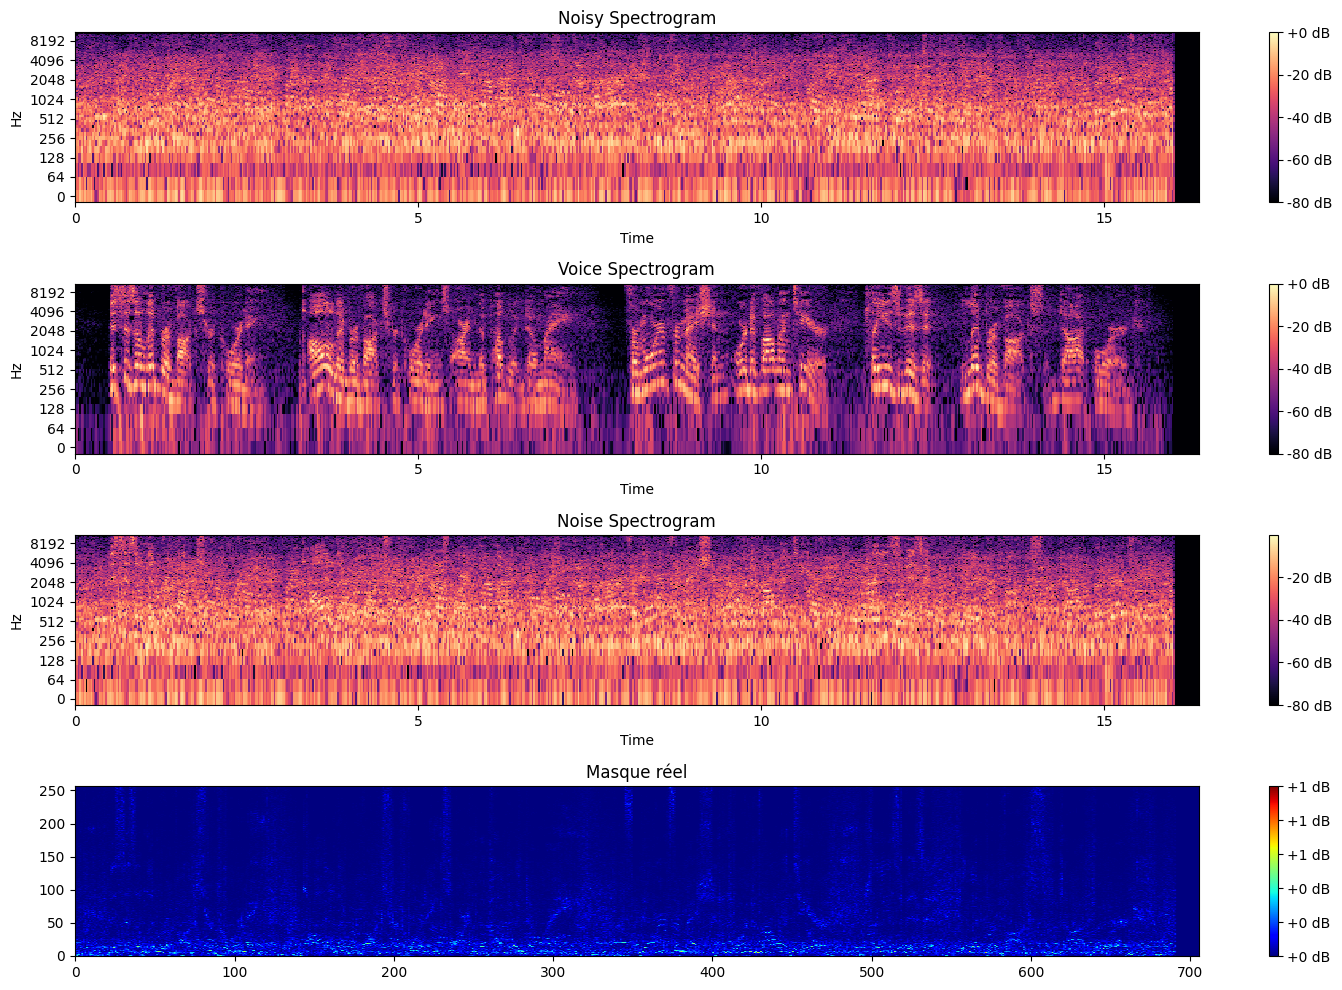

In [13]:
from matplotlib.colors import Normalize
# Exemple pour l'ensemble d'entraînement
for example_data in train_loader:
    noisy_log, mask, noise_stft, voice_stft, noisy_stft = example_data
    # Reste du code...

    # Supposons que le premier élément du lot soit suffisant
    mask_example = mask[0].numpy()
    noise_stft_example = noise_stft[0].numpy()
    voice_stft_example = voice_stft[0].numpy()
    noisy_stft_example = noisy_stft[0].numpy()

    

plt.figure(figsize=(15, 10))

# Spectrogramme de Noisy
plt.subplot(4, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(noise_stft_example, ref=np.max), y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Noisy Spectrogram')

# Spectrogramme de Voice
plt.subplot(4, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(voice_stft_example, ref=np.max), y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Voice Spectrogram')

# Spectrogramme de Noise
plt.subplot(4, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(noisy_stft_example, ref=np.max), y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Noise Spectrogram')

# Masque
# Masque
plt.subplot(4, 1, 4)
plt.imshow(mask_example, aspect='auto', origin='lower', cmap='jet', norm=Normalize(vmin=0, vmax=1))
plt.title('Masque réel')
plt.colorbar(format='%+2.0f dB')


plt.tight_layout()
plt.show()

In [27]:
torch.cuda.empty_cache()

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [35]:
import torch.optim as optim

model = SpeechEnhancementDNN(input_size=257*706)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


RuntimeError: [enforce fail at alloc_cpu.cpp:80] data. DefaultCPUAllocator: not enough memory: you tried to allocate 131172405248 bytes.

In [23]:
num_epochs = 10
for epoch in range(num_epochs):
    for batch in train_loader:
        # Imprimer le lot complet
        print(batch)
        
        # Ajustez le déballage en fonction de la structure du lot
        # Par exemple, si le lot est une liste avec deux éléments, utilisez batch[0] et batch[1]
        # Si le lot est un dictionnaire, utilisez batch['noisy_log'] et batch['mask'] ou similaire
        noisy_log, mask = batch[0], batch[1]  # Ajustez cela en fonction de la structure du lot
        print("Noisy Log shape:", noisy_log.shape)
        print("Mask shape:", mask.shape)
        optimizer.zero_grad()
        output_mask = model(noisy_log)
        loss = loss_function(output_mask, mask)
        
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


C:\Users\DELL\AppData\Local\Temp\ipykernel_13996\2567976363.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  voice_stft_norm = torch.tensor(self.STFTNormalizer.normalize_l2(voice_stft), dtype=torch.float32)
C:\Users\DELL\AppData\Local\Temp\ipykernel_13996\2567976363.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise_stft_norm = torch.tensor(self.STFTNormalizer.normalize_l2(noise_stft), dtype=torch.float32)
C:\Users\DELL\AppData\Local\Temp\ipykernel_13996\2567976363.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = to

[tensor([[[2.5341e-01, 8.8362e-02, 3.7656e-02,  ..., 4.7233e-01,
          2.1608e-01, 4.2682e-01],
         [1.3958e-01, 2.0142e-02, 2.3114e-02,  ..., 3.1326e-01,
          2.5126e-01, 2.3518e-01],
         [7.2895e-03, 5.7052e-02, 4.7296e-02,  ..., 9.3340e-02,
          2.6510e-01, 2.1345e-02],
         ...,
         [1.1183e-03, 5.4432e-05, 2.6149e-04,  ..., 5.4573e-05,
          2.2259e-03, 2.1899e-04],
         [2.9395e-03, 2.0288e-04, 8.5264e-04,  ..., 2.1131e-04,
          5.9409e-04, 4.7526e-03],
         [3.7296e-03, 1.2618e-03, 1.3090e-03,  ..., 4.1133e-04,
          3.5568e-03, 9.3904e-03]],

        [[2.3599e-01, 1.6628e-01, 1.3498e-01,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.7181e-01, 8.7448e-02, 1.9320e-03,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [2.0248e-02, 6.9753e-03, 9.7822e-02,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [5.9772e-04, 1.5209e-04, 1.1153e-04,  ..., 0.0000e+00,
          0.00

RuntimeError: mat1 and mat2 shapes cannot be multiplied (8224x706 and 181442x256)

In [ ]:
# Sauvegarder le modèle formé
torch.save(model.state_dict(), 'speech_enhancement_model.pth')

In [16]:
# Évaluation sur l'ensemble de test
model.eval()
with torch.no_grad():
    for noisy_log,  noise_stft in test_loader:
        output_mask = model(noisy_log)
        
        # Calculer la perte
        loss = criterion(output_mask, mask)
        total_loss += loss.item()

        # Appliquer le masque et obtenir le signal séparé
        separated_stft = output_mask * noisy_stft
        separated_signal = istft_processor(separated_stft.numpy())

        
# Calculer la perte moyenne sur l'ensemble de test
average_loss = total_loss / len(test_loader)
print(f"Loss on test set: {average_loss}")

NameError: name 'model' is not defined